# Notebook for the article "The varying Earth's radiative feedback connected to the ocean energy uptake: a theoretical perspective from conceptual frameworks"

# Load necessary modules and provide path to the data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.insert(1, "../src")
import project_cmip as cmip
#cmip.cst["base"] = "/path/to/the/CMIP/data" # Uncomment and set the path to data
fig_path = "figures"

# Define data structures

In [2]:
pi_avg_start = 100       # Pre-industrial averaging starting index
w_slice = slice(0, 151)  # Slice of indexes for the whole period
e_slice = {}             # Slice of indexes for early period
l_slice = {}             # Slice of indexes for late period

# Dictionaries for storing data (keys are model name)

φc_t = {}                # TOA radiative flux (φ, pi-control, global)
φa_t = {}                # TOA radiative flux (φ, abrupt-4xCO2, global)

Tsc_t = {}               # Surface temperature (Ts)
Tsa_t = {}

N_t = {}                 # φ change wrt pi-control time average (N)

ΔTs_t = {}               # Ts change wrt pi-control time average (ΔTs)

# Two-layer model estimates

TLM = {}

# Modified two-layer model estimates

TLMm = {}

# Net Feedback

λ = {}

# Early feedback

λe = {}

# Late feedback

λl = {}

# Pattern effect

Δλ = {}

# time of sign reversal

t_rev = {}

# Extract GCM time series

In [3]:
for model in cmip.cst["models"]["ALL"].keys():
    
    if model not in [
        "GISS-E2-1-G",
    ]:

        # φ
        φc_t[model] = cmip.load_variable(
            "φ_t",
            model_id=model,
            exp_type="piControl",
            time_avg="yearly",
            space_avg="global",
        )
        φa_t[model] = cmip.load_variable(
            "φ_t",
            model_id=model,
            exp_type="abrupt-4xCO2",
            time_avg="yearly",
            space_avg="global",
        )

        # Ts
        Tsc_t[model] = cmip.load_variable(
            "T_s",
            model_id=model,
            exp_type="piControl",
            time_avg="yearly",
            space_avg="global",
        )
        Tsa_t[model] = cmip.load_variable(
            "T_s",
            model_id=model,
            exp_type="abrupt-4xCO2",
            time_avg="yearly",
            space_avg="global",
        )

        # N
        N_t[model] = φa_t[model] - φc_t[model][-pi_avg_start:].mean()

        # ΔTs
        ΔTs_t[model] = Tsa_t[model] - Tsc_t[model][-pi_avg_start:].mean()

# Perform calculations on the GCM data

In [4]:
for model in N_t:
    
    ΔTs = ΔTs_t[model][w_slice][0:]
    N = N_t[model][w_slice][0:]
    
    temp = cmip.clima.TLM_params_Geoffroy_a(ΔTs, N)
    tempp = list(temp[0:5])
    tempp.append(1.0)
    tempp = tuple(tempp)
    tsol = cmip.clima.Two_Layer_Model_interpolator(*tempp)
    TLM[model] = {
        "F": temp[0],
        "Cu": temp[1],
        "Cd": temp[2],
        "λ": temp[3],
        "γ": temp[4],
        "ε": 1.0,
        "ΔTs_eq": temp[5],
        "τ_fast": temp[6],
        "τ_slow": temp[7],
        "Tu":tsol[0],
        "Td":tsol[1],
        "Nu":tsol[2],
        "Nd":tsol[3],
        "N":tsol[4],
    }
    
    temp = cmip.clima.TLM_params_Geoffroy_b(ΔTs, N, ϵ=1e-4)
    tsol = cmip.clima.Two_Layer_Model_interpolator(*temp[0:6])
    TLMm[model] = {
        "F": temp[0],
        "Cu": temp[1],
        "Cd": temp[2],
        "λ": temp[3],
        "γ": temp[4],
        "ε": temp[5],
        "ΔTs_eq": temp[6],
        "τ_fast": temp[7],
        "τ_slow": temp[8],
        "Tu":tsol[0],
        "Td":tsol[1],
        "Nu":tsol[2],
        "Nd":tsol[3],
        "N":tsol[4],
    }
    
    param = [TLMm[model][list(TLMm[model].keys())[i]] for i in range(1, 6)]
    t_rev[model] = cmip.clima.TLM_t_rev(*param)
    e_slice[model] = slice(0, round(t_rev[model]))
    l_slice[model] = slice(round(t_rev[model]), 151)
    
    temp = cmip.clima.regr.OLS_lin2d(ΔTs, N).beta
    λ[model] = {
        "regression": temp[1],
        "TLM": cmip.clima.TLM_net_feedback_mean(0, 150, *param)
    }
    
    temp = cmip.clima.regr.OLS_lin2d(ΔTs[e_slice[model]], N[e_slice[model]]).beta
    λe[model] = {
        "regression": temp[1],
        "TLM": cmip.clima.TLM_net_feedback_def(0, *param)
    }
    
    temp = cmip.clima.regr.OLS_lin2d(ΔTs[l_slice[model]], N[l_slice[model]]).beta
    λl[model] = {
        "regression": temp[1],
        "TLM": cmip.clima.TLM_net_feedback_def(150, *param)
    }
    
    Δλ[model] = {
        "regression": λl[model]["regression"] - λe[model]["regression"],
        "TLM": λl[model]["TLM"] - λe[model]["TLM"]
    }

../src/calctool.py:1303: RuntimeWarning: invalid value encountered in log1p
  τ_fast = np.nanmean(t[idxi:idxf] / (np.log(a_fast) - np.log1p(τ_fast)))


# Ensemble means and standard deviations of the modified TLM parameters

In [5]:
TLMm_mean = {"Geoffroy":{}, "CMIP5":{}, "CMIP6":{}, "ALL":{}}
for key in ["F", "Cu", "Cd", "λ", "γ", "ε", "ΔTs_eq"]:
    for ensemble in TLMm_mean:
        lista = set(TLMm.keys())
        if ensemble not in ["ALL", "Geoffroy"]:
            lista = lista.intersection(set(cmip.cst["models"][ensemble]))
        if ensemble == "Geoffroy":
            lista = [
                "bcc-csm1-1",
                "BNU-ESM",
                "CanESM2",
                "CCSM4",
                "CNRM-CM5",
                "GFDL-ESM2M",
                "inmcm4",
                "MIROC5",
                "MPI-ESM-LR",
                "MRI-CGCM3",
                "NorESM1-M",
            ]
        TLMm_mean[ensemble][key] = cmip.clima.np.array(
            [TLMm[model][key] for model in lista]
        ).mean()
print(TLMm_mean)

TLMm_std = {"Geoffroy":{}, "CMIP5":{}, "CMIP6":{}, "ALL":{}}
for key in ["F", "Cu", "Cd", "λ", "γ", "ε", "ΔTs_eq"]:
    for ensemble in TLMm_mean:
        lista = set(TLMm.keys())
        if ensemble not in ["ALL", "Geoffroy"]:
            lista = lista.intersection(set(cmip.cst["models"][ensemble]))
        if ensemble == "Geoffroy":
            lista = [
                "bcc-csm1-1",
                "BNU-ESM",
                "CanESM2",
                "CCSM4",
                "CNRM-CM5",
                "GFDL-ESM2M",
                "inmcm4",
                "MIROC5",
                "MPI-ESM-LR",
                "MRI-CGCM3",
                "NorESM1-M",
            ]
        TLMm_std[ensemble][key] = cmip.clima.np.array(
            [TLMm[model][key] for model in lista]
        ).std()
print(TLMm_std)

{'Geoffroy': {'F': 7.461101605104371, 'Cu': 8.208709496782483, 'Cd': 115.24843117524183, 'λ': -1.2513498905878415, 'γ': 0.680445820419548, 'ε': 1.1815090521223353, 'ΔTs_eq': 6.115298927125277}, 'CMIP5': {'F': 7.520337776521098, 'Cu': 8.531171100202151, 'Cd': 105.16741126553046, 'λ': -1.2119669613875208, 'γ': 0.679690608229034, 'ε': 1.2607229853365538, 'ΔTs_eq': 6.523193114669762}, 'CMIP6': {'F': 7.4812568410195786, 'Cu': 8.057845433700106, 'Cd': 95.88407546637433, 'λ': -1.0231602096173764, 'γ': 0.6624377474674334, 'ε': 1.3002256389514146, 'ΔTs_eq': 8.235824836842704}, 'ALL': {'F': 7.5000457523183846, 'Cu': 8.285405850287626, 'Cd': 100.34721767750709, 'λ': -1.113932686429946, 'γ': 0.6707323920643569, 'ε': 1.281233978559655, 'ΔTs_eq': 7.412444201182636}}
{'Geoffroy': {'F': 0.8542197595833586, 'Cu': 0.7787038469589289, 'Cd': 63.69494637992086, 'λ': 0.19543610674709302, 'γ': 0.13330941147749326, 'ε': 0.1822270633914056, 'ΔTs_eq': 1.1675570127676582}, 'CMIP5': {'F': 0.9539416005839153, 'Cu'

# CMIP5 ensemble modified TLM parameter table

In [6]:
data = {model: t_rev[model] for model in t_rev}
max_len = max([len(model) for model in cmip.cst["models"]["ALL"]])

header = "Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev"
line = "{0:15s} {1:7.2f} {2:7.2f} {3:7.2f} {4:7.2f} {5:7.2f} {6:7.2f} {7:7.2f} {8:7.2f}"

print(header)
lista = list(set(N_t.keys()).intersection(set(cmip.cst["models"]["CMIP5"])))
lista.sort()
for model in lista:
    pars = (
        model, TLMm[model]["F"], TLMm[model]["λ"], TLMm[model]["ΔTs_eq"],
        TLMm[model]["Cu"], TLMm[model]["Cd"], TLMm[model]["γ"], TLMm[model]["ε"],
        data[model]
    )
    print(line.format(*pars))

Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev
ACCESS1-0          6.72   -0.77    8.76    8.67   91.50    0.78    1.48   16.68
ACCESS1-3          6.75   -0.78    8.61    8.82  119.66    0.75    1.54   18.31
BNU-ESM            7.22   -0.94    7.70    6.91   91.98    0.55    0.97   21.66
CCSM4              8.24   -1.34    6.16    7.05   81.76    0.85    1.30   12.32
CNRM-CM5           7.04   -1.12    6.27    8.29   98.98    0.53    0.92   24.84
CNRM-CM5-2         7.25   -1.05    6.92    7.52  126.44    0.68    1.06   19.95
CanESM2            8.03   -1.02    7.84    7.47   76.36    0.54    1.25   19.32
FGOALS-g2          6.66   -0.88    7.59    8.03   67.00    0.60    1.55   17.15
GFDL-ESM2G         6.86   -1.48    4.64    5.92  111.17    0.86    1.17   11.71
GFDL-ESM2M         6.78   -1.38    4.89    8.27  121.95    0.93    1.20   14.71
GISS-E2-H_a        8.29   -1.67    4.98    9.29   90.02    0.65    1.26   17.62
GISS-E2-H_b        7.88   -1.66    4.73 

# CMIP6 ensemble modified TLM parameter table

In [7]:
data = {model: t_rev[model] for model in t_rev}
max_len = max([len(model) for model in cmip.cst["models"]["ALL"]])

header = "Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev"
line = "{0:15s} {1:7.2f} {2:7.2f} {3:7.2f} {4:7.2f} {5:7.2f} {6:7.2f} {7:7.2f} {8:7.2f}"

print(header)
lista = list(set(N_t.keys()).intersection(set(cmip.cst["models"]["CMIP6"])))
lista.sort()
for model in lista:
    pars = (
        model, TLMm[model]["F"], TLMm[model]["λ"], TLMm[model]["ΔTs_eq"],
        TLMm[model]["Cu"], TLMm[model]["Cd"], TLMm[model]["γ"], TLMm[model]["ε"],
        data[model]
    )
    print(line.format(*pars))

Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev
ACCESS-CM2         7.30   -0.67   10.93    8.97  104.34    0.56    1.45   24.11
ACCESS-ESM1-5      6.63   -0.69    9.55    8.34  101.39    0.63    1.61   19.44
BCC-CSM2-MR        6.47   -1.05    6.15    8.93   75.69    0.73    1.24   17.63
CAMS-CSM1-0        8.47   -1.85    4.58    9.54   62.31    0.60    1.26   16.90
CESM2              8.11   -0.64   12.58    8.12   78.37    0.69    1.67   16.17
CESM2-FV2          7.22   -0.51   14.10    7.81   92.77    0.72    1.75   16.06
CESM2-WACCM        7.80   -0.70   11.11    7.81   90.52    0.76    1.55   15.68
CESM2-WACCM-FV2    6.69   -0.58   11.50    6.95  110.33    0.75    1.45   16.51
CMCC-CM2-SR5       7.94   -1.07    7.44    8.45   72.93    0.55    1.33   19.87
CNRM-CM6-1-HR      7.24   -0.86    8.38    8.65   94.50    0.64    0.89   24.82
CNRM-ESM2-1        5.73   -0.63    9.05    6.97  105.76    0.56    0.89   26.16
CanESM5_a          7.59   -0.66   11.53 

# CMIP5 + CMIP6 ensemble modified TLM parameter table

In [8]:
data = {model: t_rev[model] for model in t_rev}
max_len = max([len(model) for model in cmip.cst["models"]["ALL"]])

header = "Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev"
line = "{0:15s} {1:7.2f} {2:7.2f} {3:7.2f} {4:7.2f} {5:7.2f} {6:7.2f} {7:7.2f} {8:7.2f}"

print(header)
lista = list(N_t.keys())
lista.sort()
for model in lista:
    pars = (
        model, TLMm[model]["F"], TLMm[model]["λ"], TLMm[model]["ΔTs_eq"],
        TLMm[model]["Cu"], TLMm[model]["Cd"], TLMm[model]["γ"], TLMm[model]["ε"],
        data[model]
    )
    print(line.format(*pars))

Model              F       λ       ΔTs_eq  Cu      Cd      γ       ε      t_rev
ACCESS-CM2         7.30   -0.67   10.93    8.97  104.34    0.56    1.45   24.11
ACCESS-ESM1-5      6.63   -0.69    9.55    8.34  101.39    0.63    1.61   19.44
ACCESS1-0          6.72   -0.77    8.76    8.67   91.50    0.78    1.48   16.68
ACCESS1-3          6.75   -0.78    8.61    8.82  119.66    0.75    1.54   18.31
BCC-CSM2-MR        6.47   -1.05    6.15    8.93   75.69    0.73    1.24   17.63
BNU-ESM            7.22   -0.94    7.70    6.91   91.98    0.55    0.97   21.66
CAMS-CSM1-0        8.47   -1.85    4.58    9.54   62.31    0.60    1.26   16.90
CCSM4              8.24   -1.34    6.16    7.05   81.76    0.85    1.30   12.32
CESM2              8.11   -0.64   12.58    8.12   78.37    0.69    1.67   16.17
CESM2-FV2          7.22   -0.51   14.10    7.81   92.77    0.72    1.75   16.06
CESM2-WACCM        7.80   -0.70   11.11    7.81   90.52    0.76    1.55   15.68
CESM2-WACCM-FV2    6.69   -0.58   11.50 

# NT-Diagram showing models with strong, medium and inverted couplings

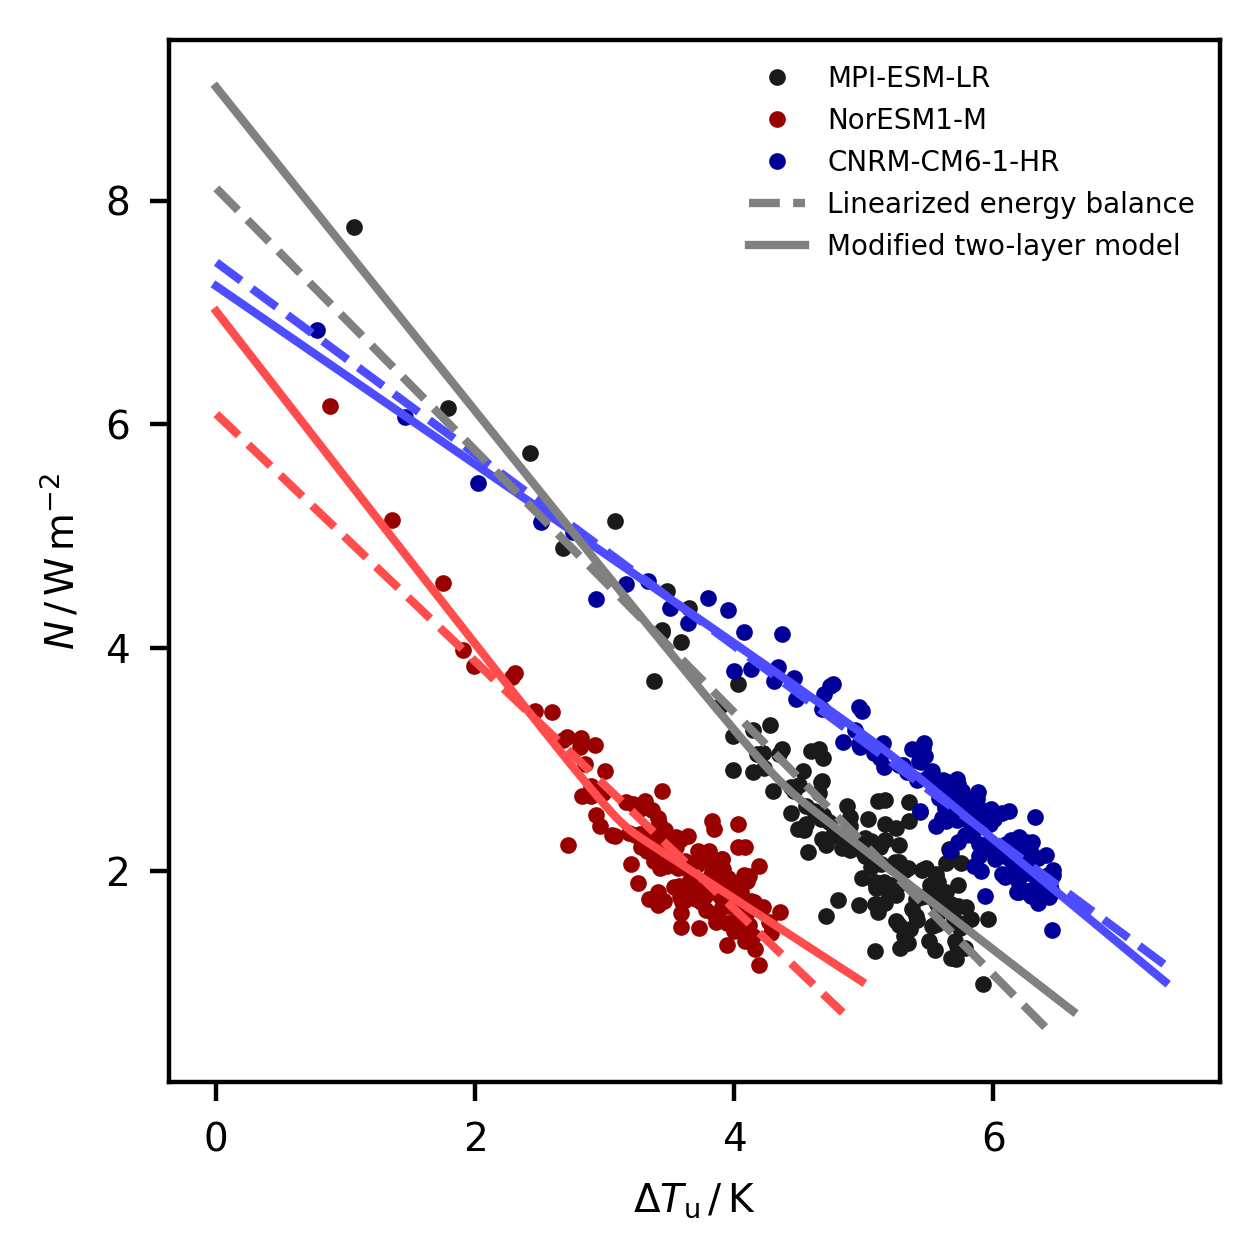

In [9]:
fig = cmip.plt.figure(figsize=(3.25, 3.25), dpi=400)
axes = fig.add_subplot(1,1,1)
t = cmip.clima.np.linspace(0, 300, 1000)

model = "MPI-ESM-LR"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0.1,0.1,0.1), label=model)

model = "NorESM1-M"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0.6,0,0), label=model)
axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(1,0.3,0.3), ls="--")
axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(1,0.3,0.3))

model = "CNRM-CM6-1-HR"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0,0,0.6), label=model)
axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(0.3,0.3,1), ls="--")
axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(0.3,0.3,1))

model = "MPI-ESM-LR"
axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(0.5,0.5,0.5), ls="--", label = "Linearized energy balance")
axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(0.5,0.5,0.5), label = "Modified two-layer model")

axes.locator_params(axis="x", nbins=7)
axes.locator_params(axis="y", nbins=8)
axes.tick_params(which="both", labelsize=7)
axes.set_xlabel("$\Delta T_{\mathrm{u}}\,/\,\mathrm{K}$", fontsize=7)
axes.set_ylabel(
    "$N\,/\,\mathrm{W}\,\mathrm{m}^{-2}$",
    fontsize=7,
)
axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp.png", bbox_inches="tight")

NTD_xlim = axes.get_xlim()
NTD_ylim = axes.get_ylim()

# Change in feedback: GCMs versus theory

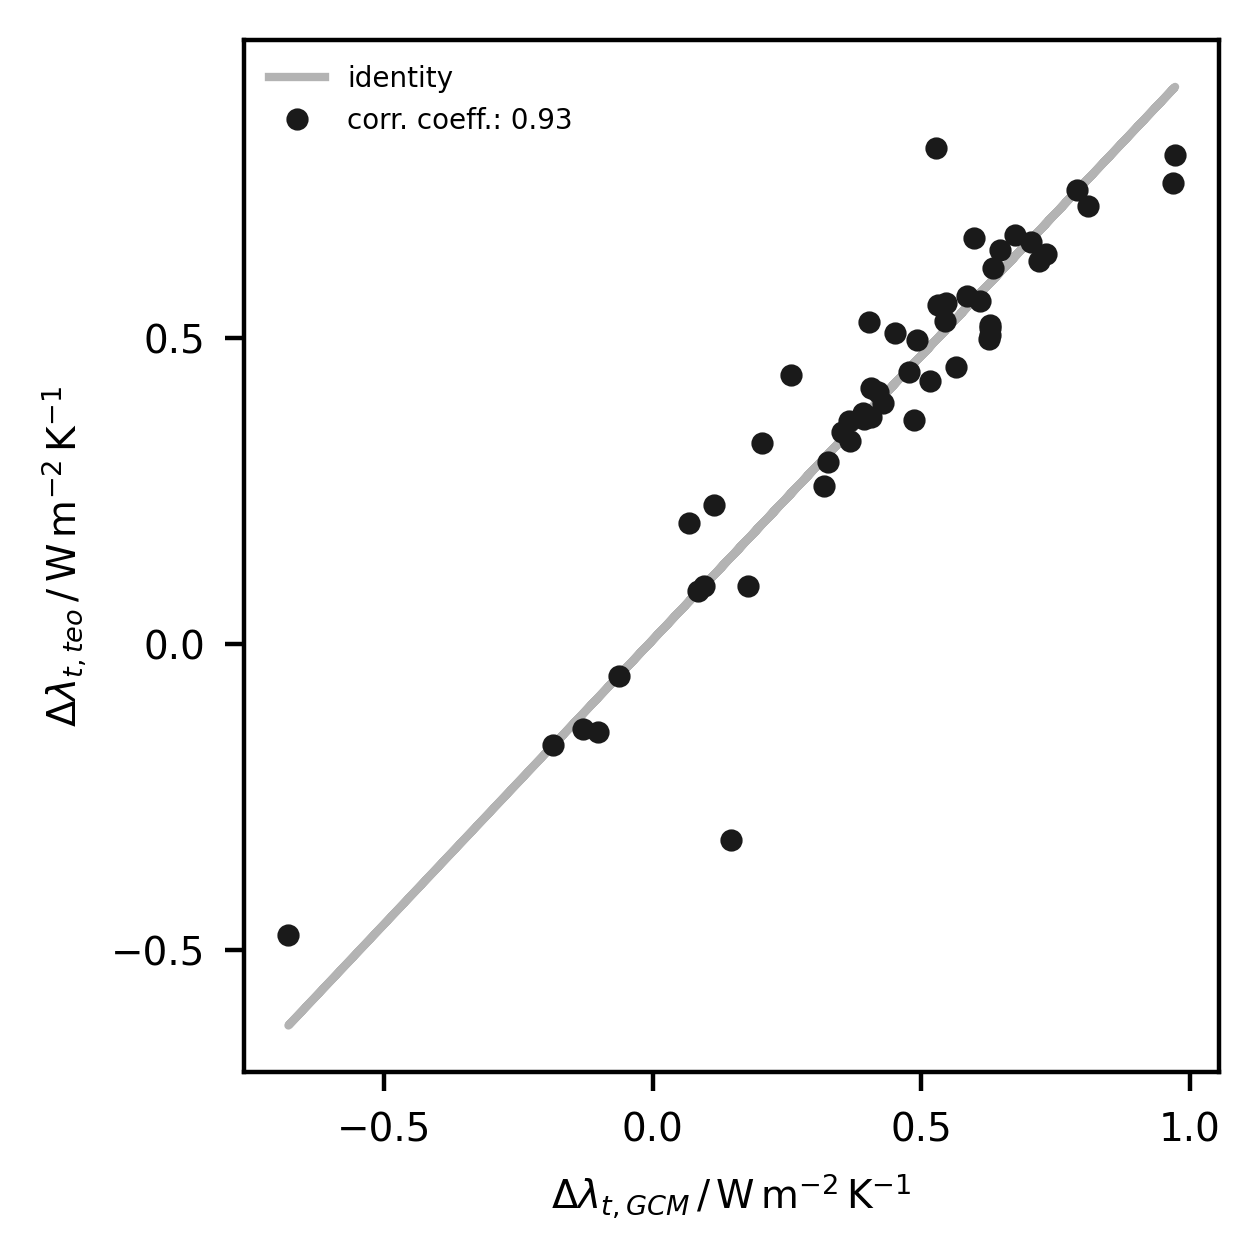

In [10]:
data1 = cmip.clima.np.array([Δλ[model]["regression"] for model in t_rev])
data2 = cmip.clima.np.array([Δλ[model]["TLM"] for model in t_rev])

data2_id = (data2.std() / data1.std()) * (data1 - data1.mean()) + data2.mean()

fig = cmip.plt.figure(figsize=(3.25, 3.25), dpi=400)
axes = fig.add_subplot(1,1,1)

corr = cmip.clima.regr.corrcoef(data1, data2)

axes.plot(data1, data2_id, color=(0.7,0.7,0.7), label=f"identity")
axes.plot(data1, data2, ls="", marker="o", markersize=3, color=(0.1,0.1,0.1), label=f"corr. coeff.: {corr:0.2f}")

axes.locator_params(axis="x", nbins=6)
axes.locator_params(axis="y", nbins=6)
axes.tick_params(which="both", labelsize=7)

axes.set_xlabel(
    "$\Delta\lambda_{t,GCM}\,/\,\mathrm{W}\,\mathrm{m}^{-2}\,\mathrm{K}^{-1}$",
    fontsize=7,
)
axes.set_ylabel(
    "$\Delta\lambda_{t,teo}\,/\,\mathrm{W}\,\mathrm{m}^{-2}\,\mathrm{K}^{-1}$",
    fontsize=7,
)
axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig02_cfp.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig02_cfp.png", bbox_inches="tight")

# Box plot showing the ensemble distribution of the t_rev timescale

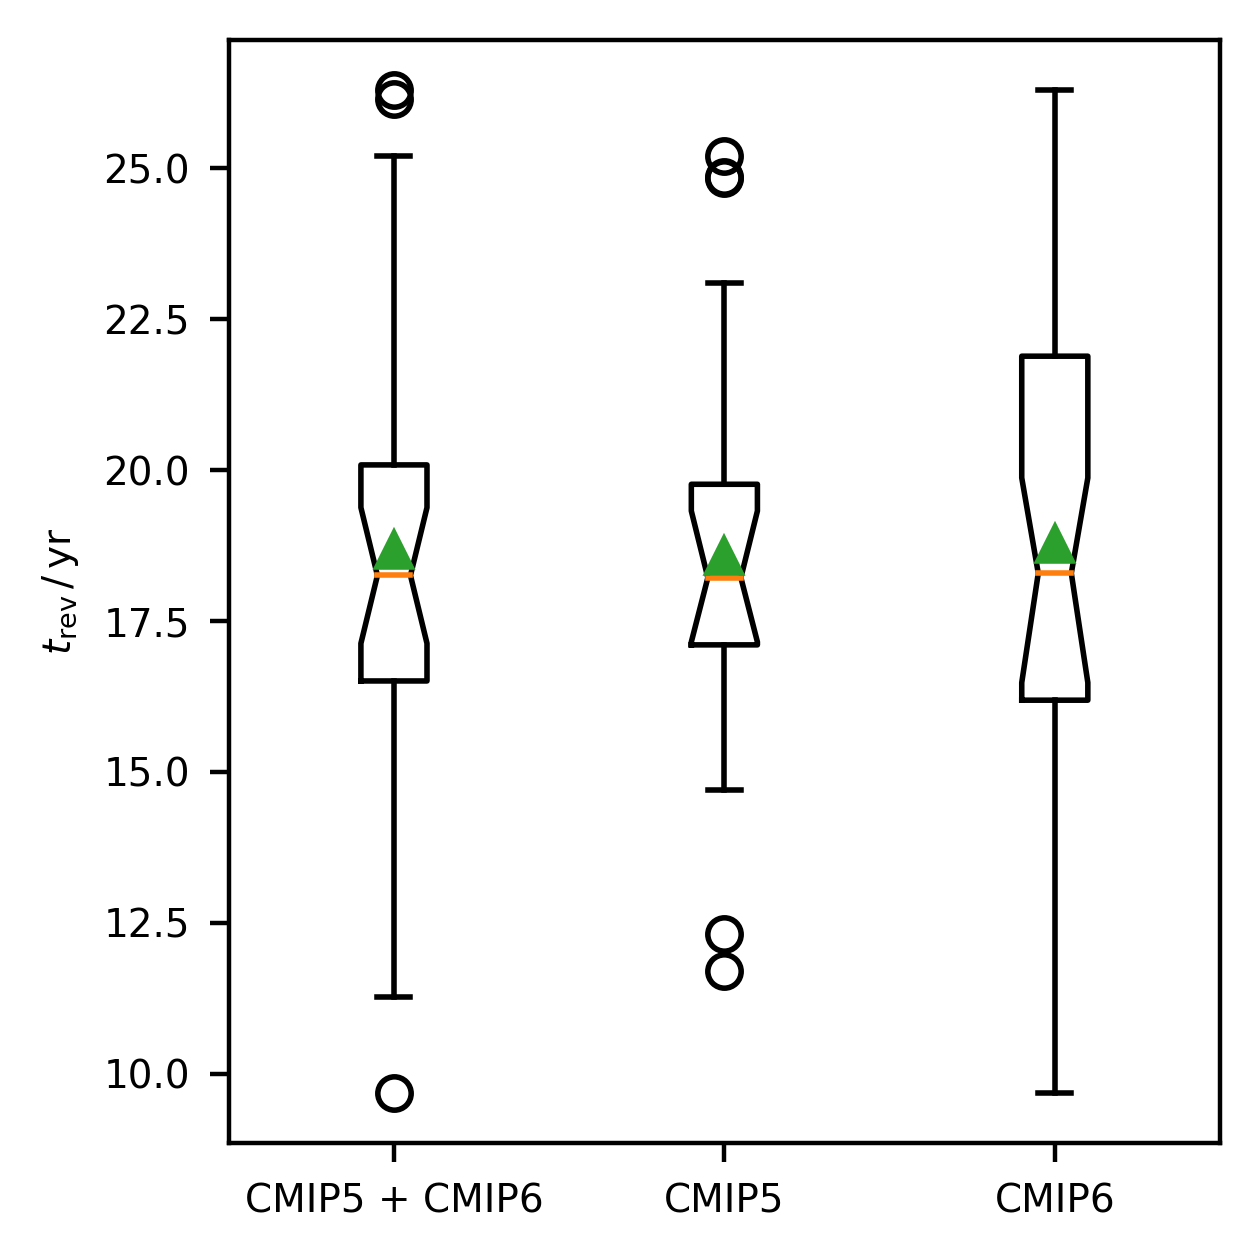

In [11]:
data = cmip.clima.np.array([t_rev[model] for model in t_rev])
data5 = cmip.clima.np.array([t_rev[model] for model in t_rev if model in cmip.cst["models"]["CMIP5"]])
data6 = cmip.clima.np.array([t_rev[model] for model in t_rev if model in cmip.cst["models"]["CMIP6"]])

fig = cmip.plt.figure(figsize=(3.25, 3.25), dpi=400)
axes = fig.add_subplot(1,1,1)
axes.boxplot([data, data5, data6], notch=True, bootstrap=100000, widths=0.2, showmeans=True)
# parts = axes.violinplot([data, data5, data6], points=100000, showmeans=False, showmedians=False, showextrema=False, widths=0.5)
# for pc in parts["bodies"]:
#     pc.set_facecolor((0.8, 0.8, 0.8))
#     pc.set_alpha(1)

axes.locator_params(axis="x", nbins=3)
axes.locator_params(axis="y", nbins=8)
axes.tick_params(which="both", labelsize=7)
axes.set_ylabel(
    "$t_{\mathrm{rev}}\,/\,\mathrm{yr}$",
    fontsize=7,
)
axes.set_xticklabels(["CMIP5 + CMIP6", "CMIP5", "CMIP6"])
fig.tight_layout()
fig.savefig(f"{fig_path}/fig03_cfp.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig03_cfp.png", bbox_inches="tight")

# Theoretical evolution of the net radiative feedback in the CMIP ensembles

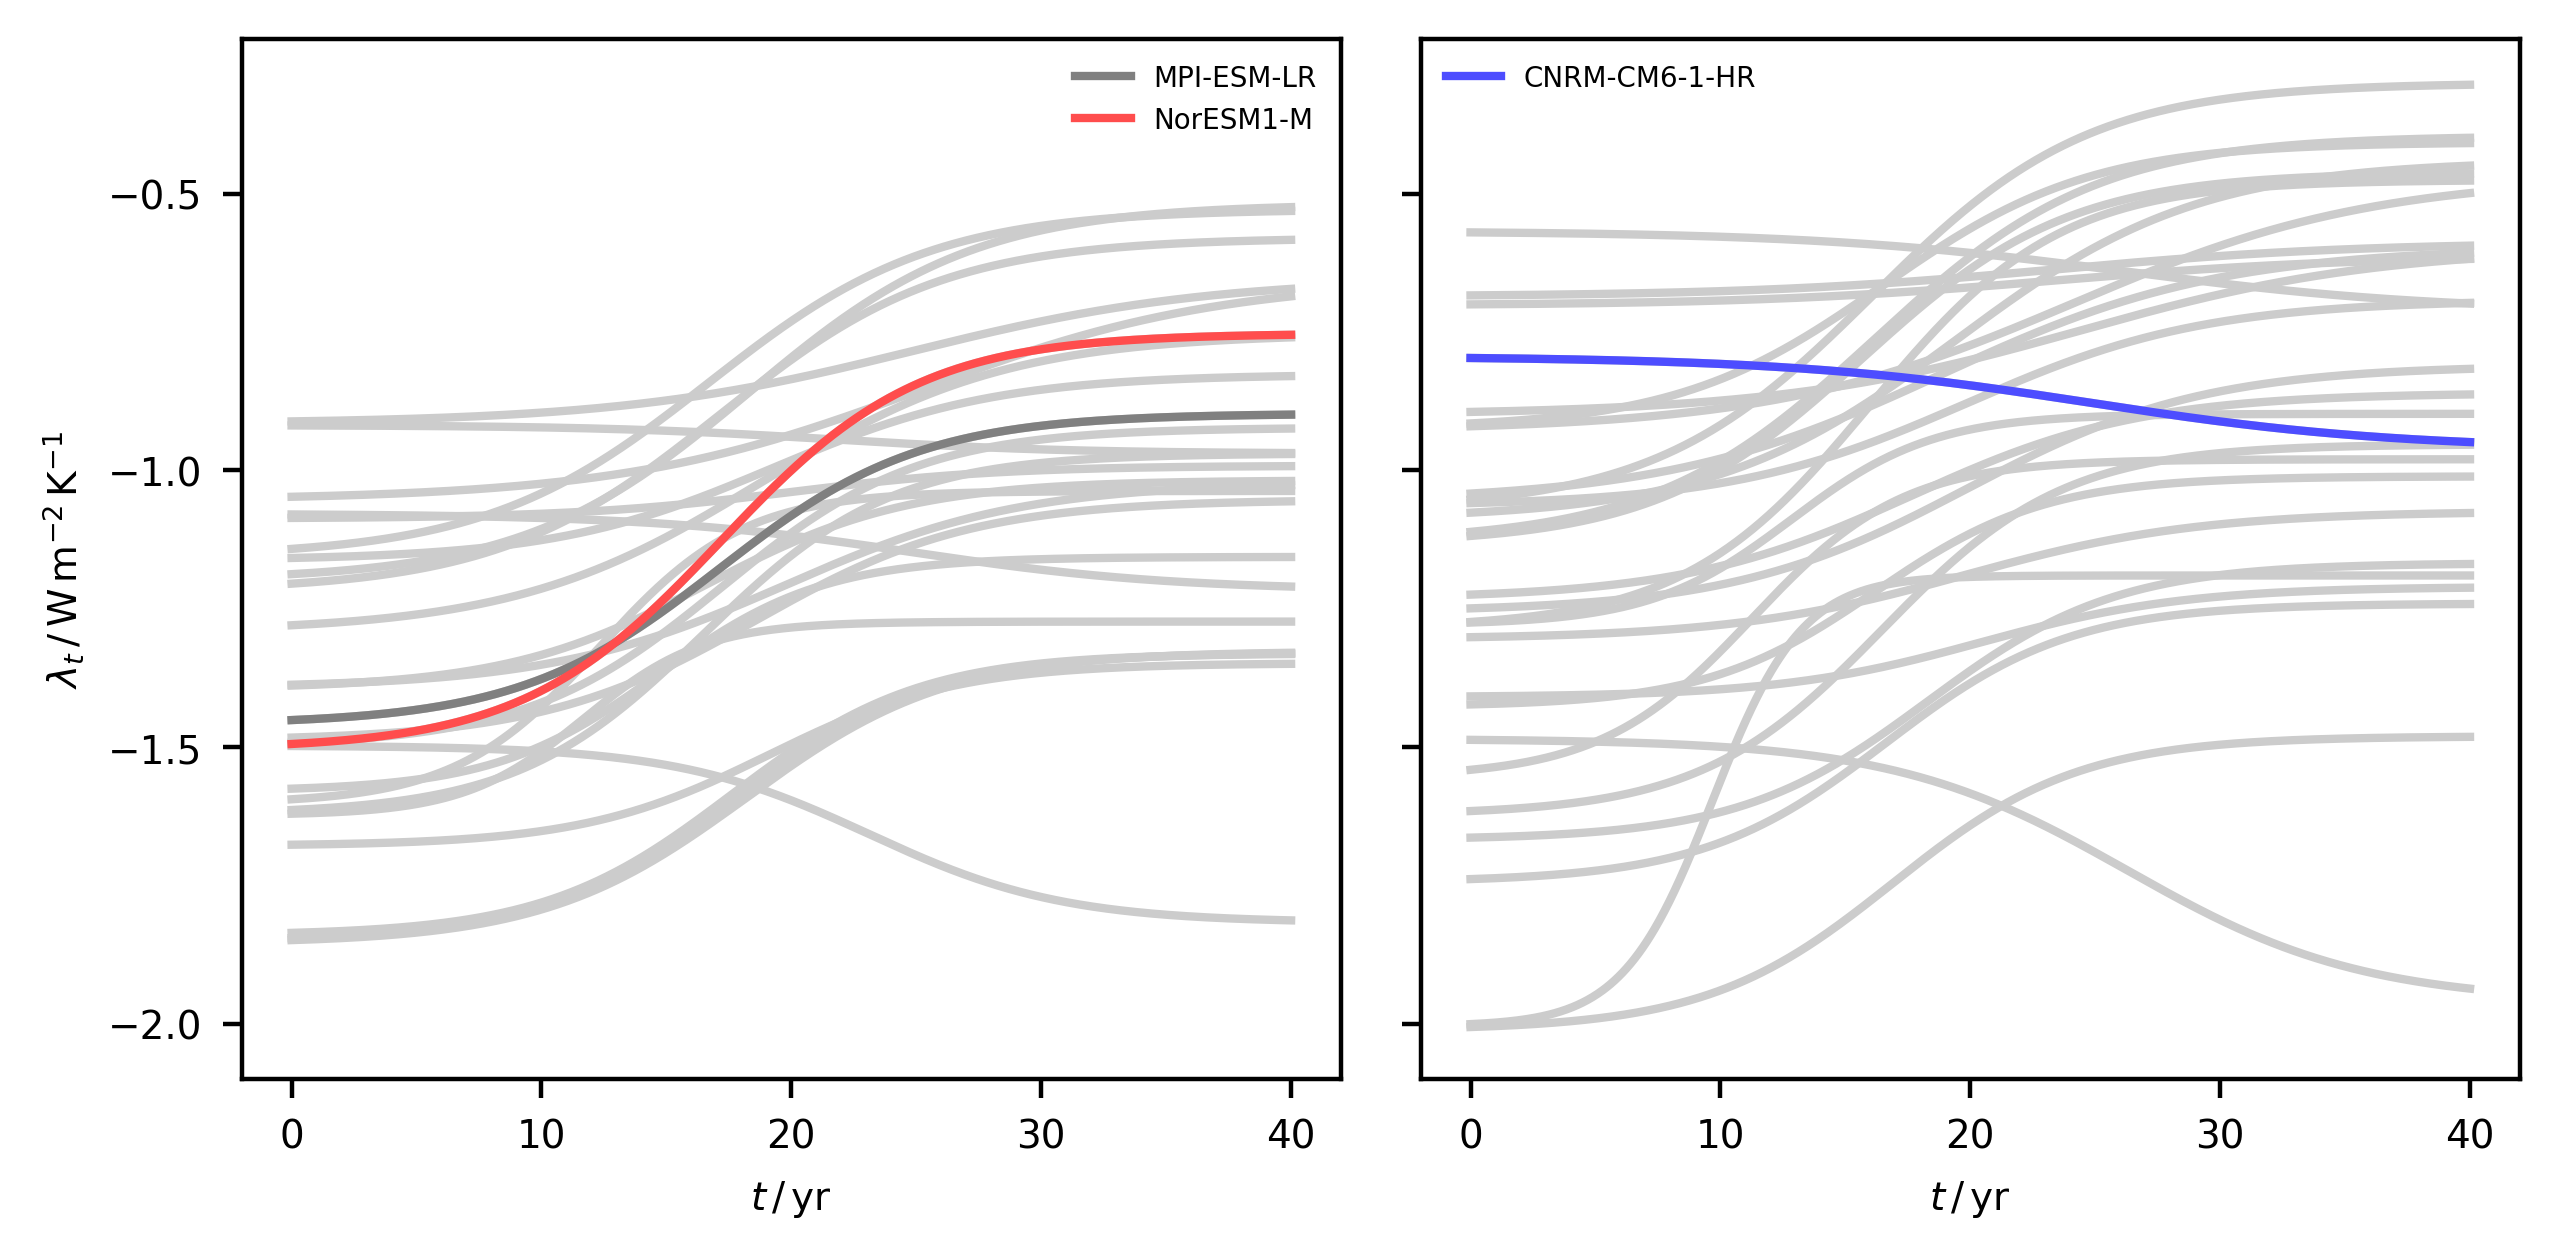

In [12]:
t = cmip.clima.np.linspace(0,40,1000)
fs1 = {}
fs2 = {}
lista1 = list(set(N_t.keys()).intersection(set(cmip.cst["models"]["CMIP5"])))
lista1.sort()
lista2 = list(set(N_t.keys()).intersection(set(cmip.cst["models"]["CMIP6"])))
lista2.sort()
for model in lista1:
    fs1[model] = cmip.clima.TLM_net_feedback(
        TLMm[model]["Cu"], TLMm[model]["Cd"],
        TLMm[model]["λ"], TLMm[model]["γ"], TLMm[model]["ε"],
    )
for model in lista2:
    fs2[model] = cmip.clima.TLM_net_feedback(
        TLMm[model]["Cu"], TLMm[model]["Cd"],
        TLMm[model]["λ"], TLMm[model]["γ"], TLMm[model]["ε"],
    )

fig = cmip.plt.figure(figsize=(2 * 3.25, 3.25), dpi=400)
axes = [fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)]

for model in fs1:
    axes[0].plot(t, fs1[model](t), color=(0.8,0.8,0.8))
    if model == "MPI-ESM-LR":
        axes[0].plot(t, fs1[model](t), color=(0.5,0.5,0.5), label=model, zorder=9)
    if model == "NorESM1-M":
        axes[0].plot(t, fs1[model](t), color=(1,0.3,0.3), label=model, zorder=9)
    if model == "CNRM-CM6-1-HR":
        axes[0].plot(t, fs1[model](t), color=(0.3,0.3,1), label=model, zorder=9)
for model in fs2:
    axes[1].plot(t, fs2[model](t), color=(0.8,0.8,0.8))
    if model == "MPI-ESM-LR":
        axes[1].plot(t, fs2[model](t), color=(0.5,0.5,0.5), label=model, zorder=9)
    if model == "NorESM1-M":
        axes[1].plot(t, fs2[model](t), color=(1,0.3,0.3), label=model, zorder=9)
    if model == "CNRM-CM6-1-HR":
        axes[1].plot(t, fs2[model](t), color=(0.3,0.3,1), label=model, zorder=9)

for ax in axes:
    ax.locator_params(axis="x", nbins=6)
    ax.locator_params(axis="y", nbins=6)
    ax.set_xlabel(
        "$t\,/\,\mathrm{yr}$",
        fontsize=7,
    )
    ax.set_ylim(-2.1, -0.22)
    ax.tick_params(which="both", labelsize=7)
    if ax == axes[0]:
        ax.set_ylabel(
            "$\lambda_{t}\,/\,\mathrm{W}\,\mathrm{m}^{-2}\,\mathrm{K}^{-1}$",
            fontsize=7,
        )
    if ax == axes[1]:
        ax.set_yticklabels([])
    ax.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig04_cfp.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig04_cfp.png", bbox_inches="tight")

# Frames for the first figure

No handles with labels found to put in legend.


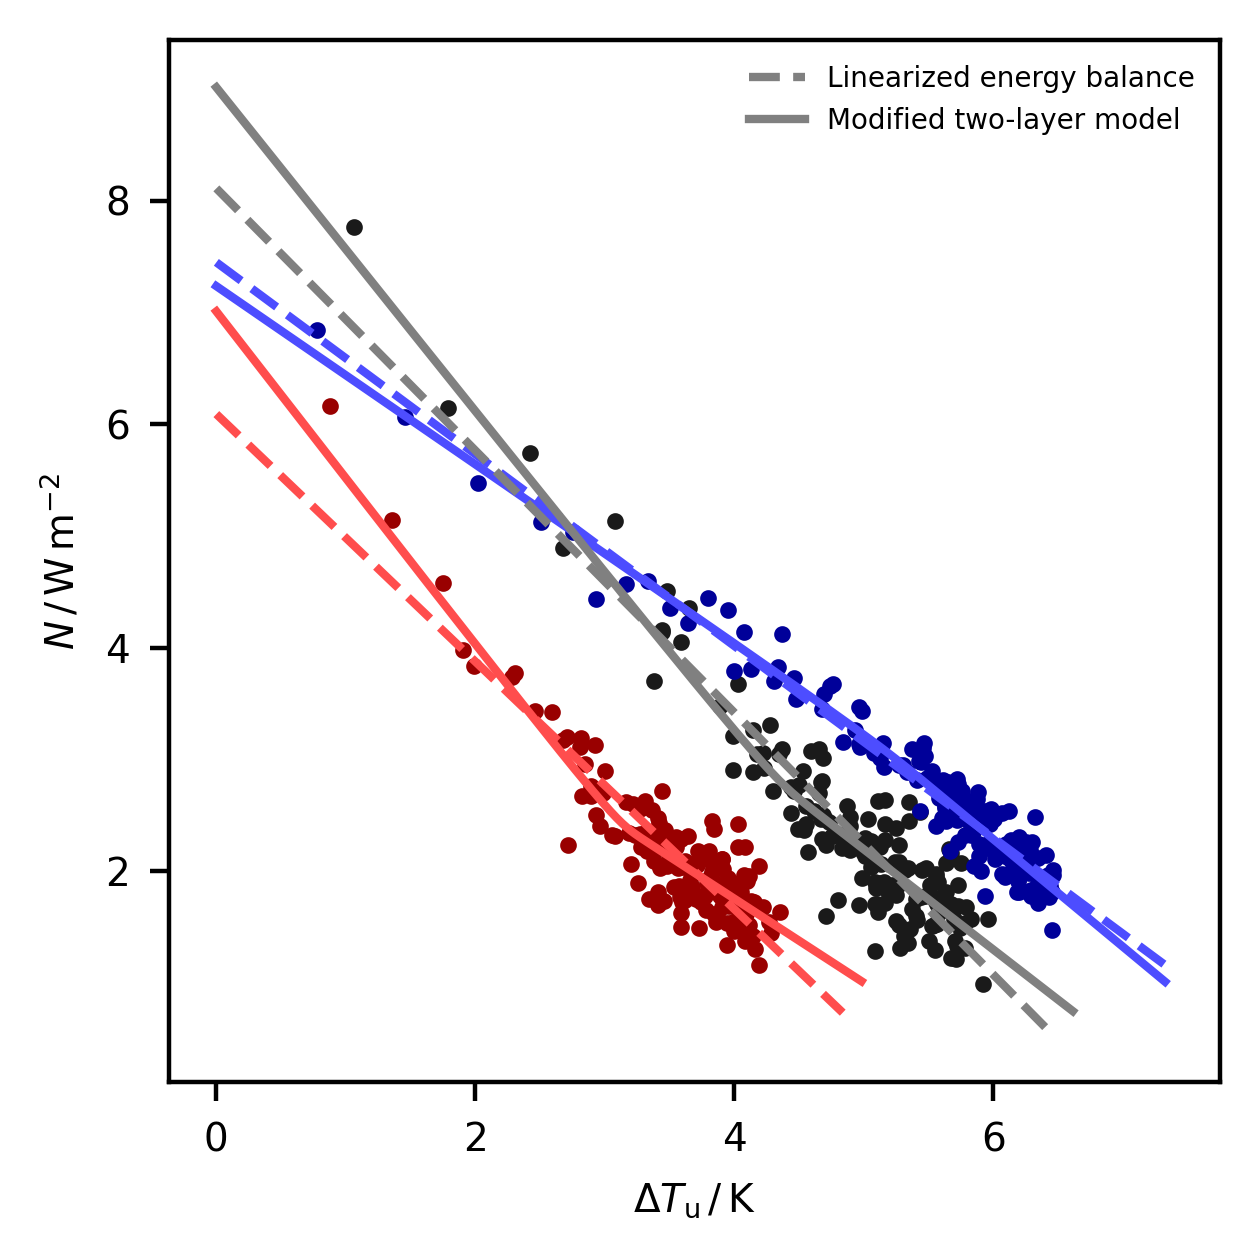

In [13]:
fig = cmip.plt.figure(figsize=(3.25, 3.25), dpi=400)
axes = fig.add_subplot(1,1,1)
axes.set_xlim(NTD_xlim)
axes.set_ylim(NTD_ylim)
axes.locator_params(axis="x", nbins=7)
axes.locator_params(axis="y", nbins=8)
axes.tick_params(which="both", labelsize=7)
axes.set_xlabel("$\Delta T_{\mathrm{u}}\,/\,\mathrm{K}$", fontsize=7)
axes.set_ylabel(
    "$N\,/\,\mathrm{W}\,\mathrm{m}^{-2}$",
    fontsize=7,
)

t = cmip.clima.np.linspace(0, 300, 1000)

model = "MPI-ESM-LR"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0.1,0.1,0.1))

axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp_frame01.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp_frame01.png", bbox_inches="tight")

axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(0.5,0.5,0.5), ls="--", label = "Linearized energy balance", zorder=10)

axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp_frame02.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp_frame02.png", bbox_inches="tight")

axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(0.5,0.5,0.5), label = "Modified two-layer model", zorder=10)

axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp_frame03.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp_frame03.png", bbox_inches="tight")

model = "NorESM1-M"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0.6,0,0))
axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(1,0.3,0.3), ls="--")
axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(1,0.3,0.3))

axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp_frame04.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp_frame04.png", bbox_inches="tight")

model = "CNRM-CM6-1-HR"
axes.plot(ΔTs_t[model][w_slice], N_t[model][w_slice], ls="", marker="o", markersize=2, color=(0,0,0.6))
axes.plot(TLM[model]["Tu"](t), TLM[model]["N"](t), lw=1.5, color=(0.3,0.3,1), ls="--")
axes.plot(TLMm[model]["Tu"](t), TLMm[model]["N"](t), lw=1.5, color=(0.3,0.3,1))

axes.legend(frameon=False, fancybox=False, fontsize=5)
fig.tight_layout()
fig.savefig(f"{fig_path}/fig01_cfp_frame05.pdf", bbox_inches="tight")
fig.savefig(f"{fig_path}/fig01_cfp_frame05.png", bbox_inches="tight")